# Representation Learning using Auto Encoders

In [1]:
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

2024-05-13 13:52:33.164016: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 13:52:33.164103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 13:52:33.296743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.2.1
TensorFlow version: 2.15.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [5]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# reshape images to 1D
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = train_images.reshape((len(train_images), 784))
test_images = test_images.reshape((len(test_images), 784))

# add noise to images
noise_factor = 0.5
x_train_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
x_test_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

train_labels = K.utils.to_categorical(train_labels, 10)
test_labels = K.utils.to_categorical(test_labels, 10)

In [6]:
# setting up the model
input_img = K.layers.Input(shape=(784,))
# encoder
encoded = K.layers.Dense(128, activation='relu')(input_img)
encoded = K.layers.Dense(64, activation='relu')(encoded)
# decoder
decoded = K.layers.Dense(128, activation='relu')(encoded)
decoded = K.layers.Dense(784, activation='sigmoid')(decoded)
autoencoder = K.Model(input_img, decoded)
encoder = K.Model(input_img, encoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# early stopping
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    restore_best_weights=True)

# autoencoder's training
autoencoder.fit(x_train_noisy, 
                train_images,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping])


Epoch 1/50
 82/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1220

I0000 00:00:1715608408.627809     138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715608408.642111     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0962

W0000 00:00:1715608409.824877     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715608410.332110     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0960 - val_loss: 0.0441
Epoch 2/50
 85/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0424

W0000 00:00:1715608410.675867     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0405 - val_loss: 0.0326
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0311 - val_loss: 0.0285
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - val_loss: 0.0262
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - val_loss: 0.0245
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0238 - val_loss: 0.0232
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0227 - val_loss: 0.0223
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.0217
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0211
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - val_loss: 0.0201
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0194 - val_loss: 0.0197
Epoch 13/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0

In [18]:
# extract hidden representations using the encoder
encoded_train_images = encoder.predict(x_train_noisy, verbose=0)
encoded_test_images = encoder.predict(x_test_noisy, verbose=0)

# set up classifier model
classifier_input = K.layers.Input(shape=(64,))
classifier_output = K.layers.Dense(10, activation='softmax')(classifier_input)
classifier = K.Model(classifier_input, classifier_output)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# early stopping
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    restore_best_weights=True)

# training the classifier
classifier.fit(encoded_train_images, train_labels,
               epochs=50, 
               batch_size=128,
               validation_split=0.2,
               verbose=0,
               callbacks=[early_stopping])

# classifier's evaluation
test_loss, test_accuracy = classifier.evaluate(encoded_test_images, test_labels)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 22.
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8461 - loss: 0.5049
Test accuracy: 0.8655999898910522, Test loss: 0.4403439462184906


In [19]:
# compute the reconstruction error on the test set
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(autoencoder.predict(x_test_noisy, verbose=0), test_images).numpy()
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction error: 0.01619076542556286


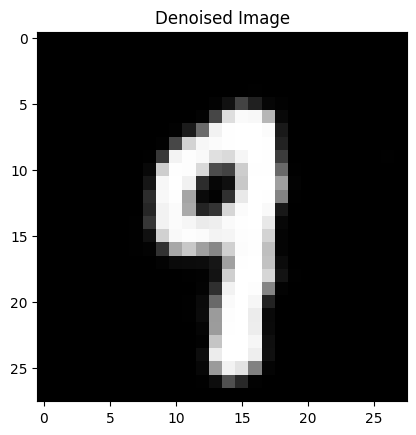

In [20]:
# generate a noise image and iteratively denoise it
noise_image = np.random.normal(loc=0, scale=1, size=(1, 784))
noise_image = np.clip(noise_image, 0., 1.)

for i in range(100):
    noise_image = autoencoder.predict(noise_image, verbose=0)

# plot the denoised image
plt.imshow(noise_image.reshape(28, 28), cmap='gray')
plt.title("Denoised Image")
plt.show()
